Kernel matrix is positive definite (shape: (24, 24))
Condition number of kernel matrix: 1.41e+07
Sampling from GP posterior using ESS...


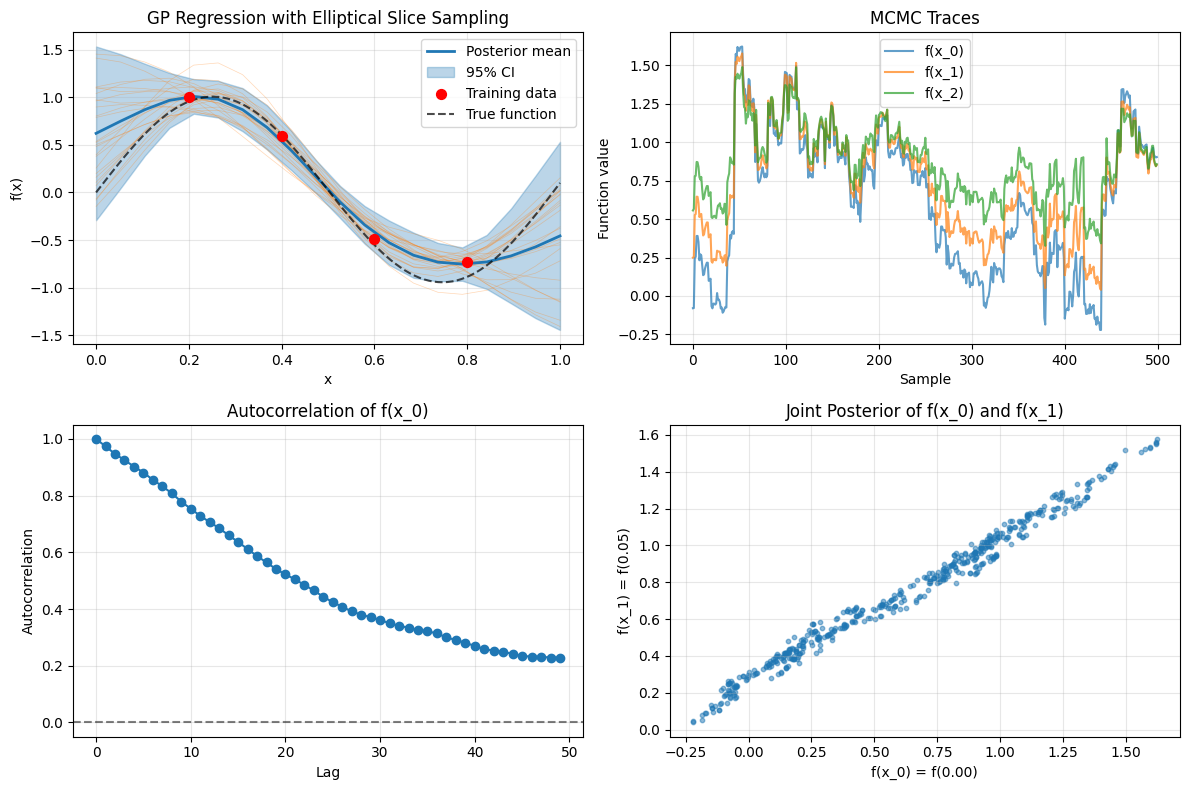

Generated 500 posterior samples for test function values
Sampling from joint distribution of 24 function values
Training points: 4, Test points: 20
Effective sample size (ESS) for f(x_0):  10.0
Posterior mean at first 5 test points: [0.62069743 0.74829388 0.87002105 0.96697581 1.00866113]
Posterior std at first 5 test points: [0.45627626 0.35220873 0.24095223 0.14440841 0.09077995]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import cdist


class EllipticalSliceSampler:
    """
    Elliptical Slice Sampler for sampling from posteriors with Gaussian priors.

    Reference: Murray, I., Adams, R. P., & MacKay, D. J. (2010).
    Elliptical slice sampling. In Proceedings of the thirteenth international
    conference on artificial intelligence and statistics (pp. 541-548).
    """

    def __init__(self, log_likelihood_fn, prior_cov):
        """
        Initialize the ESS sampler.

        Args:
            log_likelihood_fn: Function that takes f and returns log p(y|f)
            prior_cov: Prior covariance matrix Σ such that f ~ N(0, Σ)
        """
        self.log_likelihood_fn = log_likelihood_fn
        self.prior_cov = prior_cov
        self.prior_chol = cholesky(prior_cov, lower=True)

    def sample_prior(self):
        """Sample from the prior f ~ N(0, Σ)"""
        z = np.random.standard_normal(self.prior_cov.shape[0])
        return self.prior_chol @ z

    def step(self, f_current):
        """
        Perform one ESS step.

        Args:
            f_current: Current state

        Returns:
            f_new: New sample
        """
        # Step 1: Draw auxiliary variable from prior
        nu = self.sample_prior()

        # Step 2: Define the ellipse f(θ) = f cos θ + ν sin θ

        # Step 3: Slice sampling - choose random likelihood threshold
        log_y = self.log_likelihood_fn(f_current) + np.log(np.random.random())

        # Step 4: Find bracket of angles θ where likelihood > threshold
        # Start with a random angle
        theta = np.random.uniform(0, 2 * np.pi)
        theta_min = theta - 2 * np.pi
        theta_max = theta + 2 * np.pi

        # Shrink bracket until we find valid range
        while True:
            f_proposal = f_current * np.cos(theta) + nu * np.sin(theta)

            if self.log_likelihood_fn(f_proposal) > log_y:
                return f_proposal

            # Shrink bracket
            if theta < 0:
                theta_min = theta
            else:
                theta_max = theta

            # Sample new angle from shrunk bracket
            theta = np.random.uniform(theta_min, theta_max)

    def sample(self, n_samples, f_init=None, burn_in=100):
        """
        Generate samples using ESS.

        Args:
            n_samples: Number of samples to generate
            f_init: Initial state (if None, sample from prior)
            burn_in: Number of burn-in samples

        Returns:
            samples: Array of samples (n_samples x dimension)
        """
        if f_init is None:
            f_current = self.sample_prior()
        else:
            f_current = f_init.copy()

        samples = []

        # Burn-in
        for i in range(burn_in):
            f_current = self.step(f_current)

        # Collect samples
        for i in range(n_samples):
            f_current = self.step(f_current)
            samples.append(f_current.copy())

        return np.array(samples)


class GPRegression:
    """Gaussian Process Regression setup for ESS."""

    def __init__(self, X_train, y_train, X_test, kernel_fn, noise_var=0.1):
        """
        Initialize GP regression problem.

        We'll sample f at ALL points (train + test) and use the likelihood
        y_train ~ N(f_train, σ²I) where f ~ N(0, K_joint)

        Args:
            X_train: Training inputs (n_train x d)
            y_train: Training outputs (n_train,)
            X_test: Test inputs where we want to sample f values (n_test x d)
            kernel_fn: Kernel function k(x1, x2)
            noise_var: Observation noise variance
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.noise_var = noise_var
        self.kernel_fn = kernel_fn
        self.n_train = len(X_train)
        self.n_test = len(X_test)

        # Combine all points for joint sampling
        self.X_all = np.vstack([X_train, X_test])

        # Compute joint kernel matrix with regularization for numerical stability
        self.K_joint = kernel_fn(self.X_all, self.X_all)

        # Add small jitter to diagonal for numerical stability
        jitter = 1e-6
        self.K_joint += jitter * np.eye(len(self.X_all))

    def log_likelihood(self, f_all):
        """
        Compute log p(y_train | f_all) where f_all = [f_train; f_test]

        The likelihood is simply:
        y_train ~ N(f_train, σ²I)
        """
        f_train = f_all[: self.n_train]  # Extract training function values

        # Simple Gaussian likelihood
        residual = self.y_train - f_train
        log_lik = -0.5 * np.sum(residual**2) / self.noise_var
        log_lik -= 0.5 * self.n_train * np.log(2 * np.pi * self.noise_var)

        return log_lik


def rbf_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """RBF (Gaussian) kernel function."""
    dists = cdist(X1, X2, metric="euclidean")
    return variance * np.exp(-0.5 * dists**2 / lengthscale**2)


# Demo: GP regression with ESS
def demo_gp_ess():
    """Demonstrate ESS for GP regression."""

    # Generate synthetic training data
    np.random.seed(42)
    X_train = np.array([[0.2], [0.4], [0.6], [0.8]])

    def true_f(x):
        return np.sin(2 * np.pi * x.flatten()) + 0.1 * x.flatten() ** 2

    y_train = true_f(X_train) + 0.1 * np.random.randn(len(X_train))

    # Test points where we want to sample function values
    X_test = np.linspace(0, 1, 20).reshape(-1, 1)

    # Set up GP regression
    def kernel_fn(X1, X2):
        return rbf_kernel(X1, X2, lengthscale=0.3, variance=1.0)

    gp = GPRegression(X_train, y_train, X_test, kernel_fn, noise_var=0.01)

    # Check if kernel matrix is positive definite
    try:
        np.linalg.cholesky(gp.K_joint)
        print(f"Kernel matrix is positive definite (shape: {gp.K_joint.shape})")
    except np.linalg.LinAlgError:
        print("Warning: Kernel matrix is not positive definite!")

    print(f"Condition number of kernel matrix: {np.linalg.cond(gp.K_joint):.2e}")

    # Set up ESS sampler - now uses joint kernel matrix
    sampler = EllipticalSliceSampler(gp.log_likelihood, gp.K_joint)

    # Generate samples
    print("Sampling from GP posterior using ESS...")
    samples_all = sampler.sample(n_samples=500, burn_in=200)

    # Extract test function values (last n_test columns)
    samples = samples_all[:, gp.n_train :]  # Extract f_test samples

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot function samples
    plt.subplot(2, 2, 1)
    for i in range(0, len(samples), 20):  # Plot every 20th sample
        plt.plot(X_test.flatten(), samples[i], "C1-", alpha=0.3, linewidth=0.5)

    # Plot mean and confidence intervals
    mean_f = np.mean(samples, axis=0)
    std_f = np.std(samples, axis=0)
    plt.plot(X_test.flatten(), mean_f, "C0-", linewidth=2, label="Posterior mean")
    plt.fill_between(
        X_test.flatten(),
        mean_f - 2 * std_f,
        mean_f + 2 * std_f,
        alpha=0.3,
        color="C0",
        label="95% CI",
    )

    # Plot training data and true function
    plt.scatter(
        X_train.flatten(), y_train, c="red", s=50, zorder=10, label="Training data"
    )
    x_fine = np.linspace(0, 1, 100)
    plt.plot(
        x_fine, true_f(x_fine.reshape(-1, 1)), "k--", alpha=0.7, label="True function"
    )

    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("GP Regression with Elliptical Slice Sampling")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot trace of first few function values
    plt.subplot(2, 2, 2)
    for i in range(3):
        plt.plot(samples[:, i], alpha=0.7, label=f"f(x_{i})")
    plt.xlabel("Sample")
    plt.ylabel("Function value")
    plt.title("MCMC Traces")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot sample autocorrelations
    plt.subplot(2, 2, 3)
    lags = np.arange(50)
    autocorr = []
    for lag in lags:
        if lag == 0:
            autocorr.append(1.0)
        else:
            autocorr.append(np.corrcoef(samples[:-lag, 0], samples[lag:, 0])[0, 1])
    plt.plot(lags, autocorr, "o-")
    plt.axhline(0, color="k", linestyle="--", alpha=0.5)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation of f(x_0)")
    plt.grid(True, alpha=0.3)

    # Plot posterior samples in 2D (first two test points)
    plt.subplot(2, 2, 4)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
    plt.xlabel(f"f(x_0) = f({X_test[0, 0]:.2f})")
    plt.ylabel(f"f(x_1) = f({X_test[1, 0]:.2f})")
    plt.title("Joint Posterior of f(x_0) and f(x_1)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Generated {len(samples)} posterior samples for test function values")
    print(f"Sampling from joint distribution of {len(gp.X_all)} function values")
    print(f"Training points: {gp.n_train}, Test points: {gp.n_test}")
    print(
        f"Effective sample size (ESS) for f(x_0): {len(samples) / (1 + 2 * np.sum(np.abs(autocorr[1:]))): .1f}"
    )
    print(f"Posterior mean at first 5 test points: {mean_f[:5]}")
    print(f"Posterior std at first 5 test points: {std_f[:5]}")


if __name__ == "__main__":
    demo_gp_ess()